# Topic Map

In [192]:
import os
import pandas as pd
import re
import nltk
import openai
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from bertopic import BERTopic
from nltk import sent_tokenize, word_tokenize
# nltk.download('punkt')


pd.set_option('display.max_colwidth', None)
openai.api_key=os.environ['openai_api_key'] 
data_dir = '../data/'
processed_dir = data_dir + 'processed/'
os.makedirs(processed_dir + 'html', exist_ok = True)
transcription_dir_location_en = processed_dir + 'transcription/en/'

In [271]:
docs = []
filename = []
timestamps = []
docs_word_count = []
# TODO sort by date

# the text contains spoken filler words that need removed 
stopwords = ['um', 'um,', 'mm,', 'eh', 'eh,', 'eh?', 'ah', 'ah,', 'mhm', 'mhm.', 'oh', 'oh,', 'oh.', 'huh?', 'hi']     
# RegExs for significant phrases 
FDI = re.compile(re.escape("fratelli d'italia"), re.IGNORECASE)
ninety_four = re.compile(re.escape("ninety four"), re.IGNORECASE)
one_hundred_and_ninety_four = re.compile(re.escape("one hundred and ninety-four"), re.IGNORECASE)

def remove_stop_words(sentence):
    text_tokens = sentence.split(" ")
    tokens_filtered = [word for word in text_tokens if not word.lower() in stopwords]
    return (" ").join(tokens_filtered)

def parse_text(file_location): 
    transcriptions_df = pd.read_json(file_location, convert_dates=['createTime'])
    transcription_text = transcriptions_df['transcript'][0]
    transcription_create_time = transcriptions_df['createTime'][0].strftime('%Y-%m-%d %H:%M:%S')
    word_count = len(transcription_text.split()) 
    # only analyse files with sentences with more then 27 words
    if word_count < 27:
        print(f'Small number of words: {file_location} {transcription_text}')
        return
    docs_word_count.append(word_count)
    for sentence in sent_tokenize(transcription_text):
        timestamps.append(transcription_create_time)
        sentence = FDI.sub('Brothers of Italy', sentence)
        sentence = ninety_four.sub('ninety-four', sentence)
        sentence = one_hundred_and_ninety_four.sub('194', sentence)
        sentence = remove_stop_words(sentence)                 
        docs.append(sentence)
    
for file_name in os.listdir(transcription_dir_location_en):
    parse_text(transcription_dir_location_en + file_name)

print(len(timestamps))
print(len(docs))

docs_dict = zip(timestamps, docs)
    
with open(processed_dir + '/all-docs-text.txt', 'w') as file: 
	file.writelines("% s % s\n" % (key, value) for key, value in docs_dict) 

word_count_df = pd.DataFrame(zip(timestamps, docs_word_count), columns=['timestamp','word_count'])  
word_count_df.to_json(processed_dir + '/wordcount.json')

start_date = '2022-07-21'
end_date = '2022-09-26'

docs_df = pd.DataFrame(zip(timestamps, docs), columns=['timestamp','docs'])  

mask = (docs_df['timestamp'] > start_date) & (docs_df['timestamp'] <= end_date)
election_dates_df = docs_df.loc[mask]


Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147206448232074502.json gentlemen, It was the day of defeat. But this is not the day to get things done. Well, that wasn't really the case. That's fine. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147263913200045317.json September twenty-fifth I've said it all. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7135145359629634822.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144425341279341830.json I am
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7070073900100521222.json who goes M design, yo. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144420910336953606.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7143163842665663749.json 
Small number of words: ../data/processed/transcription/en/Transcribe

1) Pre-calculate Embeddings

In [20]:
from bertopic.backend import OpenAIBackend
# import spacy
# !python -m spacy download en_core_web_md
# nlp = spacy.load("en_core_web_md", exclude=['tagger', 'parser', 'ner', 
#                                             'attribute_ruler', 'lemmatizer'])
# embedding_model = OpenAIBackend('text-embedding-ada-002"')

# import gensim.downloader as api
# ft = api.load('fasttext-wiki-news-subwords-300')
# embedding_model = ft

# all-mpnet-base-v2 - best but slow
embedding_model = SentenceTransformer('all-mpnet-base-v2')

# embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

Stochastic Behaviour

In [4]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

Limit Number of Topics

In [27]:
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

Improving Default Representation

In [180]:
# max_df 0.7, 1.0 no english stop wrods
# vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
#  stop_words="english" - seems to interfere with generating topics like 'abortion' and max_df=2, min_df=2, no idea what to tweak these to. 
vectorizer_model = CountVectorizer(stop_words="english")
# vectorizer_model.fit_transform(docs)
# vectorizer_model.get_feature_names_out()

In [398]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
openai_model = OpenAI(model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

from bertopic.representation import ZeroShotClassification

candidate_topics = [
    'migrants', 
    # 'immigration',
    'abortion', 
    'fake news', 
    'Brothers of Italy', 
    'we are ready',
    'rape',
    'Nazis',
    'minimum wage',
    'ecological',
    'green pass',
    'russia'
    'crime', # thsi to seperate out from migration
    'authoritarian',
    
    'inflation', 
    'citizenship', 
    'freedom',
    'prices',
    'pensions',
    'tax',
    'family',
    # 'government'
    
    ]

zero_shot_model = ZeroShotClassification(candidate_topics, model="facebook/bart-large-mnli")

# https://joeddav.github.io/blog/2020/05/29/ZSL.html

# representation_model = zero_shot_model

    # openai_model


representation_model = {
    'KeyBERT': keybert_model,
    # 'OpenAI': openai_model,  # Uncomment if you will use OpenAI
    'MMR': mmr_model,
    # 'POS': pos_model,
    'ZeroShot': zero_shot_model,
}

## Seed Topics

In [401]:
seed_topic_list = [  
    ['Brothers of Italy', 'brothers of italy', 'Italy', 'Italian'],
    ['immigration', 'migration', 'migrants', 'refugee', 'traffickers'],
    ['abortion', 'abort', '194', 'law 194'],
    ['election', 'government', 'vote'],
    ['inflation', 'bills'],
    ['freedom'],
    ['rape', 'raped'],
    
    ['climate' , 'environmental', 'ecological',  'sustainability'],
    ['fake', 'fake news', 'lies', 'journalism'],
    ['tax', 'income'],

    ['minimum wage'],
    ['Nazis'],
    ['pensions'],
    ['crime'],
    ['family', 'families'],
    ['pets', 'animals'], # added as pets get merge into the migrants topic    
    ['we are ready'], # The FDI's Campaign slogan     
    ['russia']       
    ]

In [402]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)

topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  # vectorizer_model=                       # Step 4 -  Tokenize topics. Don't do this! It removed the entire abortion topic.
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  seed_topic_list= seed_topic_list,
  # Hyperparameters
  nr_topics='auto', # < less topics
  verbose=True,
  n_gram_range=(1,3) # allows Brothers of Italy
)

topics, probs = topic_model.fit_transform(docs)

# topic_labels = topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=15, separator=', ')
# topic_model.set_topic_labels(topic_labels)

topic_model.get_topic_info()

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

2023-10-15 11:51:41,484 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-10-15 11:51:48,354 - BERTopic - Reduced dimensionality
2023-10-15 11:51:48,396 - BERTopic - Clustered reduced embeddings
2023-10-15 11:56:52,203 - BERTopic - Reduced number of topics from 52 to 42


,Topic,Count,Name,Representation,KeyBERT,MMR,ZeroShot,Representative_Docs
0,-1,860,-1_government_italy_of the_be,"[government, italy, of the, be, in the, will, this, with, not, have]","[of italy, italy, italian, government, in italy, brothers of italy, the government, nation, to the, that we]","[government, italy, of the, be, in the, will, this, with, not, have]","[government, italy, of the, be, in the, will, this, with, not, have]","[I can speak very badly about Italy, but I do it in my home, I do it in parliament, I do it with my opponents, I do it with the Italians at home, but outside you won't hear me speaking badly about Italy, I have done something interview with fox news and I didn't do it to speak badly of Italy in case the left won, I did it to say what I want to do, I did it to explain that this nation can get back on its feet, that this nation it can still be a proud nation, it can be a nation that amazes, as it has amazed throughout its history throughout its civilization., We have started important work to make the places that our students frequent more modern and then again on young people, from the culture card to the Merit Card, in favor respectively of the kids with the lowest ISEE and the deserving ones up to the increase of the sports in the suburbs, passing through the five hundred million allocated to scholarships for university housing allocations, we have reiterated the principle that equality and merit are one prerequisite for the other from the provision to simplify the first thirty administrative procedures up to the highly anticipated reform of the procurement code we have started a profound revision to make the State more streamlined, more understandable, more efficient., And obviously it also happened that the bubble inflated so much that at a certain point those who had these credits, mainly companies, could no longer compensate them because they had exhausted, let's say, their possibility of compensating that credit with taxes and could no longer not even to sell them, because even the fiscal drawers of the banks of the other actors who could buy those credits have closed and there are perfectly honest people who have done some work, who have trusted the State, who have done what the State said which found itself in the hands of some work done and money that it cannot take because this has produced this very interesting free measure that today we have thousands of companies that risk collapse and therefore since we inherited it, we now have to look for a solution to prevent thousands of companies from risking collapse because someone could say during the election campaign that they renovated houses for free and that's exactly what we tried to do.]"
1,0,211,0_italy_brothers of italy_italian_brothers,"[italy, brothers of italy, italian, brothers, brothers of, of italy, italians, the italian, italy is, in italy]","[italian government, the italian government, of italy, italy in, of italy has, italy, the italian, italy is, that italy, italian]","[italy, brothers of italy, italian, brothers, brothers of, of italy, italians, the italian, italy is, in italy]","[italy, brothers of italy, italian, brothers, brothers of, of italy, italians, the italian, italy is, in italy]","[From the decree to protect strategic production sectors to the birth of the Committee for Made in Italy, passing through the battle that allowed us to avoid the exclusion of wine, red meat and cured meats from European funding for the promotion of agricultural products, we have reiterated that Italy intends to defend its infrastructure, its brand, its excellence from the two billion euros that we have allocated to interventions for the safety, adaptation and redevelopment of schools, of which seven hundred and ten million that we have released and one billion and two hundred million added from scratch until resources are increased to make universities more efficient for a total of one billion four hundred million., This instability ha

### Rename and format topics

In [400]:
heatmap_fig = topic_model.visualize_heatmap() # n_clusters=20, topics=[4, 18, 26, 21,44]custom_labels=True
heatmap_fig.write_html(processed_dir + 'html/similarity-matrix.html')
heatmap_fig

In [395]:

# merge topics
# migrants
# topic_model.merge_topics(docs, topics_to_merge=[4, 9])

topic_labels = topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=15, separator=', ')
topic_model.set_topic_labels(topic_labels)
def formatted_label(labels):
    names = [item[0] for item in labels if item[0]]
    top_three = ', '.join(names[:3]).replace('green pass', 'COVID Mandates')

    return top_three

updated_labels = [formatted_label(label) for label in topic_model.get_topics(full=True)['ZeroShot'].values()]

topic_model.set_topic_labels(updated_labels)

# green pass > COVID Mandates
# topic_model.set_topic_labels({1: "COVID Mandates"}) green pass > COVID Mandates 

# topic_model.set_topic_labels({1: "Abortion"})
# topic_model.set_topic_labels({2: "Immigration"})
# topic_model.set_topic_labels({3: "Fake News"})
# topic_model.set_topic_labels({4: "Freedom"})
# topic_model.set_topic_labels({14: "Taxes"})
# topic_model.set_topic_labels({14: "Cost of Living/Inflation"})
# topic_model.set_topic_labels({14: "Election Campaign"})
# topic_model.set_topic_labels({14: "Rape"})
# topic_model.set_topic_labels({14: "Climate Change"})
# topic_model.get_topic_info().head(20)

# Select interesting topics for visualisation


# # outliers why_why why
# topic_model.merge_topics(docs, topics_to_merge=[-1, 46])
# topic_model.merge_topics(docs, topics_to_merge=[29, 22])


interesting_topics=[0, 2, 3, 4, 5, 8, 9, 14, 18, 20, 27]
# If you want to change the topics to something else, whether that is merging them or removing outliers, 
# you can pass a custom list of topics to update them: topic_model.update_topics(docs, topics=my_updated_topics)
# topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
# topic_model.get_topic_info()
# representative_docs = topic_model.get_representative_docs(5)
# representative_docs
# topic_model.get_topic_info().head(50)
topic_model.get_topic_info()


,Topic,Count,Name,CustomName,Representation,KeyBERT,MMR,ZeroShot,Representative_Docs
0,-1,747,-1_government_this_who_for,"government, this, who","[government, this, who, for, their, even, want, because, in the, be]","[government, the government, that we, are, families, to the, what, income, we, our]","[government, this, who, for, their, even, want, because, in the, be]","[government, this, who, for, their, even, want, because, in the, be]","[As you know, in recent weeks and at the last meeting of the European Council, important steps forward have been made, to which concrete solutions must be given today, obviously in the shortest time possible.. And then, obviously, we talked about the resources of how to best spend the resources of the National Recovery and Resilience Plan, as well as in the face of the difficulties that exist, increase in the costs of raw materials, inflation., From the extension of the Solidarity Fund for mortgages and the guarantee fund for the purchase of the first home for young couples, through to the rule that allows everyone to transform the variable rate mortgage into a fixed rate mortgage, we have given a hand in defending the right to housing from the fiscal truce to the extension of the flat tax for self-employed and VAT numbers, up to the cut in taxation on productivity bonuses and on the highest declared incomes, through the tax relief on tips and the extension of the suspension on Plastic and Sugar Tax, we have begun to build a state that is friendlier to those who produce, from raising the ceiling to the use of cash to the norm to combat open-and-close companies., And obviously it also happened that the bubble inflated so much that at a certain point those who had these credits, mainly companies, could no longer compensate them because they had exhausted, let's say, their possibility of compensating that credit with taxes and could no longer not even to sell them, because even the fiscal drawers of the banks of the other actors who could buy those credits have closed and there are perfectly honest people who have done some work, who have trusted the State, who have done what the State said which found itself in the hands of some work done and money that it cannot take because this has produced this very interesting free measure that today we have thousands of companies that risk collapse and therefore since we inherited it, we now have to look for a solution to prevent thousands of companies from risking collapse because someone could say during the election campaign that they renovated houses for free and that's exactly what we tried to do.]"
1,0,214,0_italy_in italy_italian_government,"italy, in italy, italian","[italy, in italy, italian, government, italians, brothers of italy, the italian, nation, an, has]","[italian government, the italian government, which italy, of italy, an italy, italy in, the italian, italy, italy is, italy that]","[italy, in italy, italian, government, italians, brothers of italy, the italian, nation, an, has]","[italy, in italy, italian, government, italians, brothers of italy, the italian, nation, an, has]","[The theme here is if you want to do something, whatever you want to do, you do it respecting the rules and laws of the Italian state because there isn't some idiot who respects them and someone else who doesn't have to respect them, this Italy here, as I see it, it's over, that is, someone who knows how to do it better make their proposals but don't use hypotheses that have nothing to do with the rationale of the law and with our intention to prevent this State from saying that we are no longer the banana republic, because I don't follow them on this, I move forward and I believe that this is what Italians expect from me and from the government currently in office, This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same inte

In [390]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)
# intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, topics=interesting_topics, custom_labels=True)
intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, custom_labels=True)

intertopic_fig.write_html(processed_dir + 'html/topics-over-time.html')
intertopic_fig

166it [00:16, 10.13it/s]


### See all documents in a topic

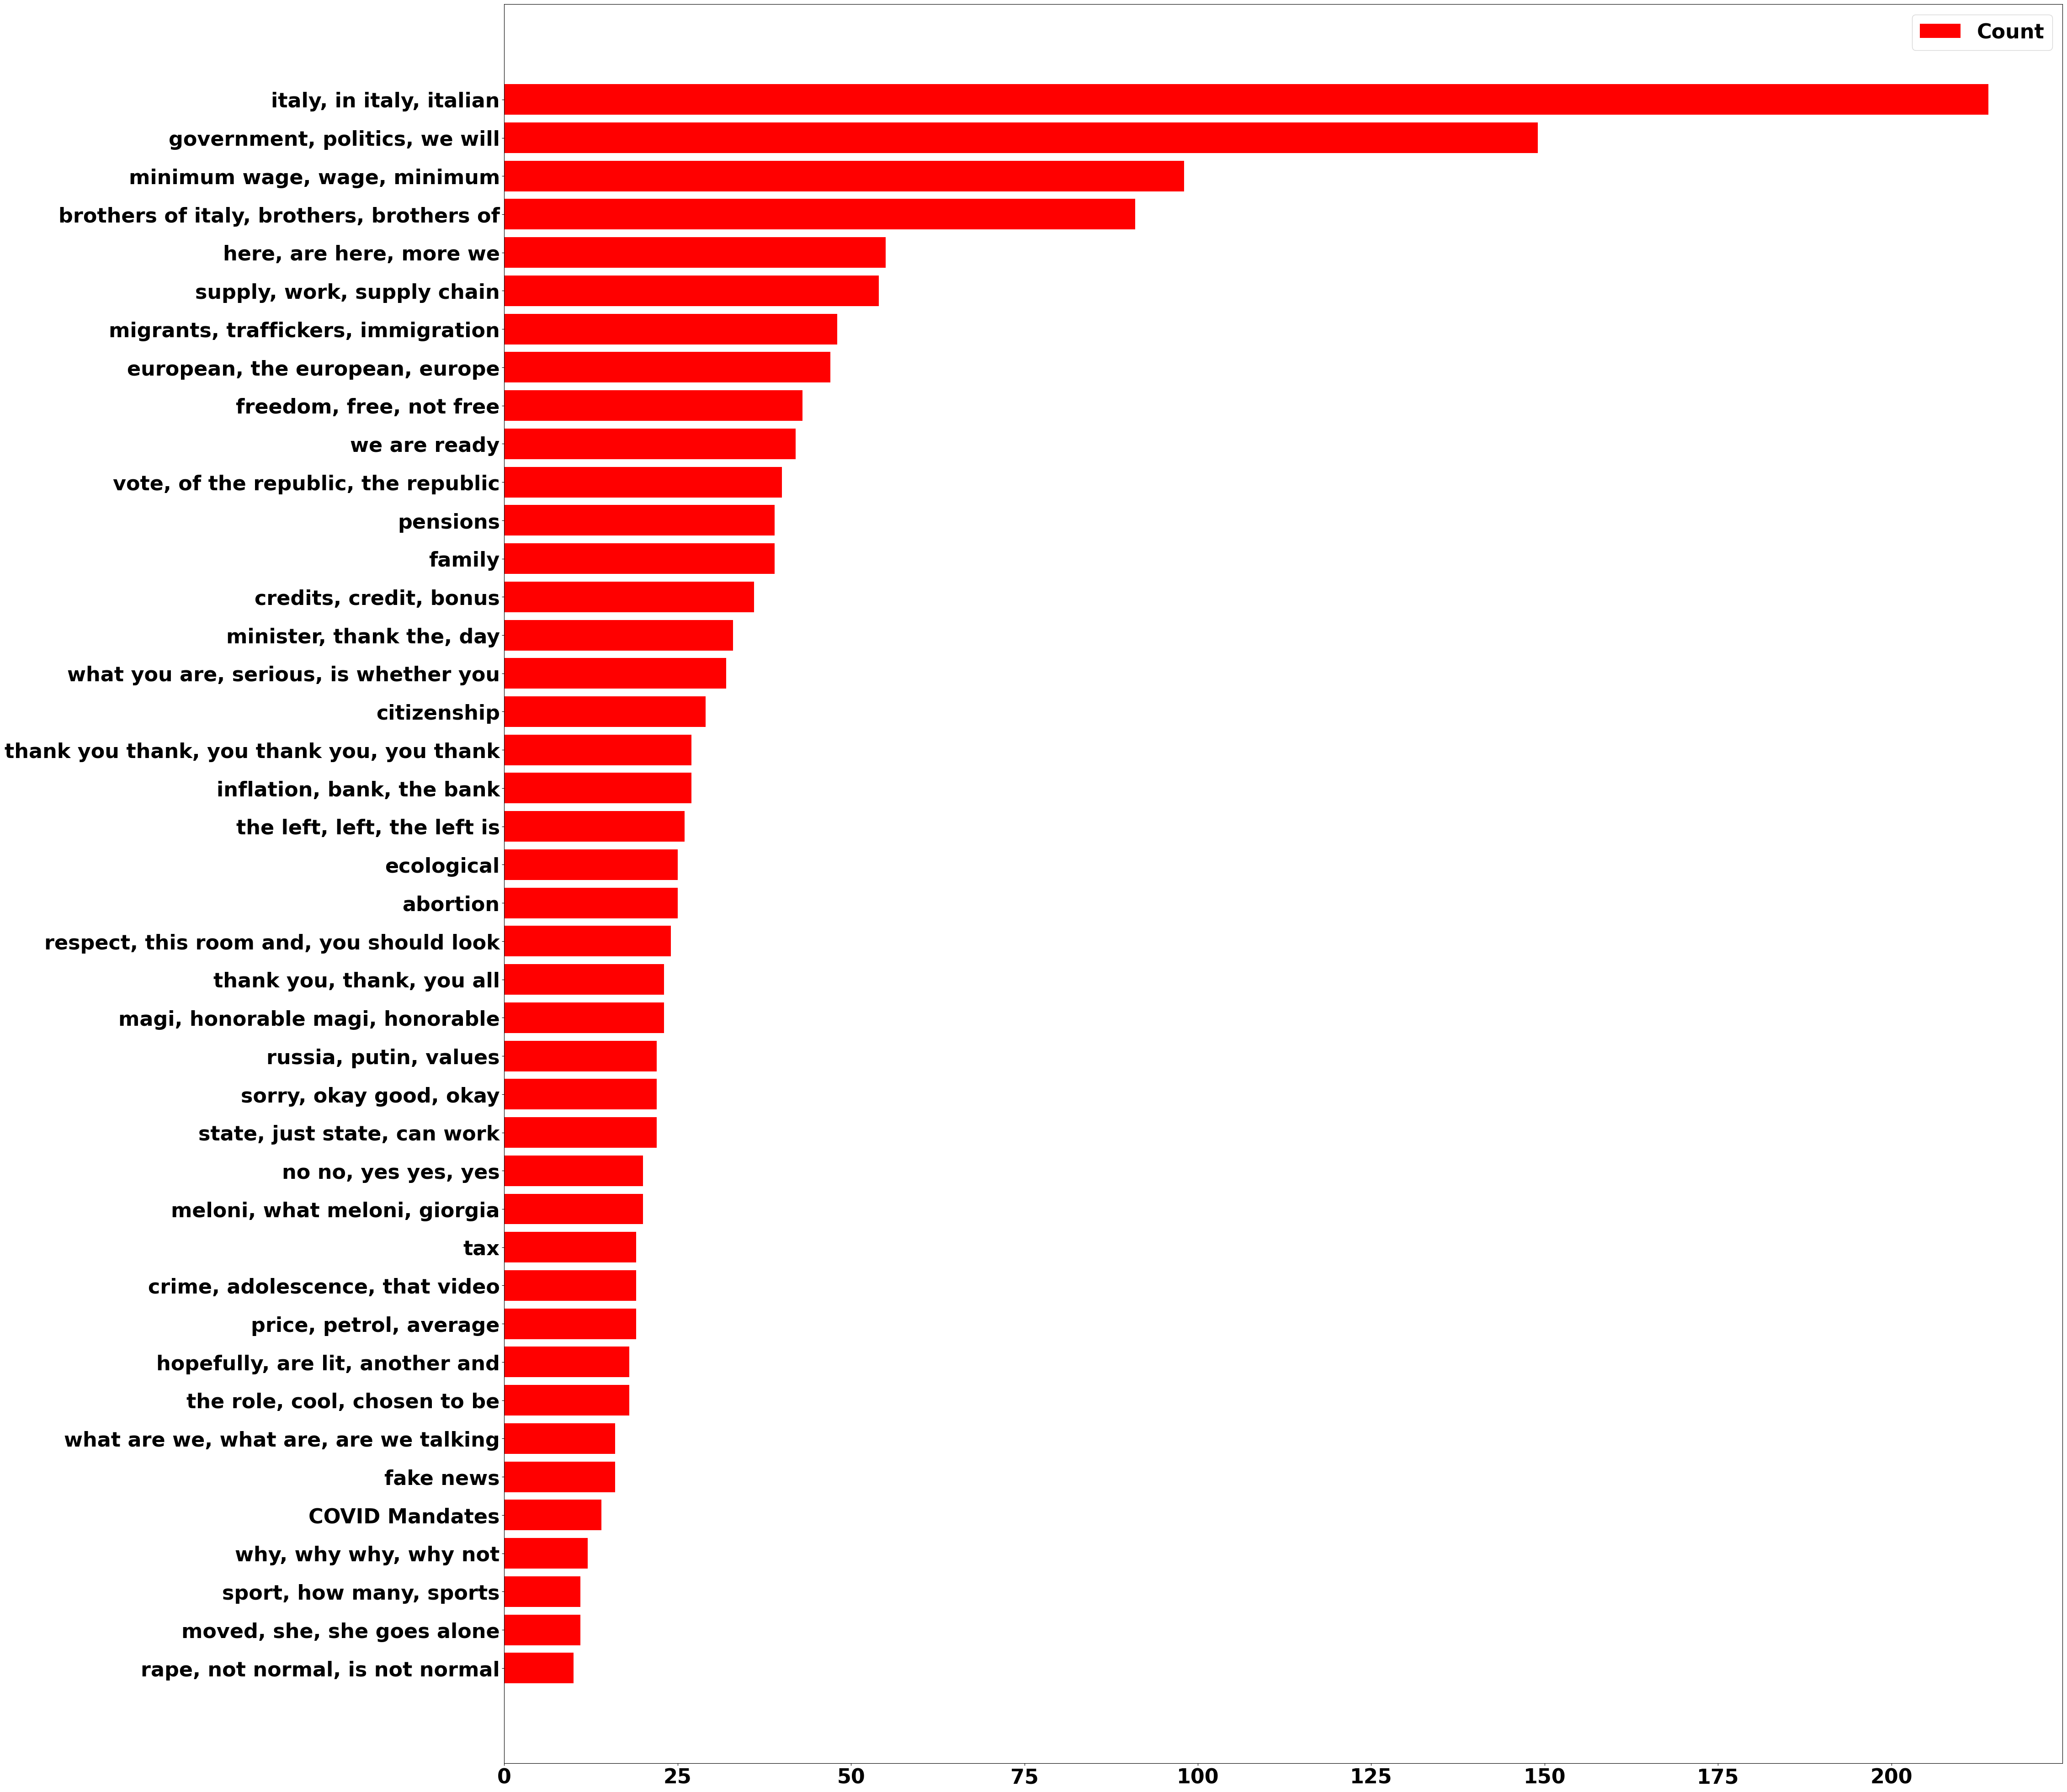

In [394]:
plt_df = topic_model.get_topic_info()
plt_df = plt_df.drop([0])
plt_df = plt_df.sort_values(by='Count', ascending=True)

f = plt.figure()
f.set_figwidth(44)
f.set_figheight(50)
plt.barh(plt_df['CustomName'], plt_df['Count'], label = "Count", color='red')
font = {'weight' : 'bold',
        'size'   : 32}
plt.rc('font', **font)
plt.legend()
plt.savefig(processed_dir + 'images/it-topic-document-counts.png')
plt.show()

In [252]:
# docs_df = topic_model.get_topic_info()
# docs_df[docs_df['Topic'] == 0].head(50)
representative_docs = topic_model.get_representative_docs(5)
representative_docs

df = pd.DataFrame({'Topic': topics, 'document': docs})
df[df['Topic'] == 0].head(50)


,Topic,document
1,0,"The government has allocated over one billion euros for Regions and autonomous provinces, to limit the impact of payback in medical devices, on companies in the sector and to strengthen emergency rooms."
2,0,"Because the scenes of degradation, abandonment, confusion that we sometimes see in a difficult moment in our lives, that is, when we need emergency healthcare, are not tolerable."
6,0,Because it has also become intolerable that workers who do delicate and difficult work to save the lives of other people also have to fear for their own safety.
13,0,We decided to take stock of our work.
22,0,"We have established the principle that those who cannot work must have assistance, but those who can work must have work from the increase in the number of families who could access discounts on bills to the resources to combat the expensive shopping cart, through the experimentation of food income."
26,0,To have the scholarship recognized.
30,0,"And then from the extension of benefits for companies in the South, the valorisation of quality production, up to the presentation of the project to transform post offices into one-stop shops for the public administration to guarantee everyone's right to have easy and fast services."
31,0,"We wanted to establish the principle that every citizen, every territory, every municipality must have the same attention."
33,0,"We have started important work to make the places that our students frequent more modern and then again on young people, from the culture card to the Merit Card, in favor respectively of the kids with the lowest ISEE and the deserving ones up to the increase of the sports in the suburbs, passing through the five hundred million allocated to scholarships for university housing allocations, we have reiterated the principle that equality and merit are one prerequisite for the other from the provision to simplify the first thirty administrative procedures up to the highly anticipated reform of the procurement code we have started a profound revision to make the State more streamlined, more understandable, more efficient."
35,0,"And then from the fifty percent increase in the single allowance for children to the halving of VAT on early childhood products, through the strengthening of parental leave."


Show the documents in a particular topic

In [100]:
fig = topic_model.visualize_barchart(width=280, height=330, top_n_topics=60, n_words=10, custom_labels=True)
fig.write_html(processed_dir + 'html/topic-word-scores.html')
fig

In [ ]:

# %%time
# model = BERTopic(
#     n_gram_range=(1, 2),
#     vectorizer_model=vectorizer_model,
#     nr_topics='auto',
#     min_topic_size=10,
#     diversity=0.7,
#     calculate_probabilities=True).fit(docs, corpus_embeddings)
# remove outliers
#  Comment out this line below if you decided to use the "propbabilities" strategy
# new_topics = model.reduce_outliers(docs, topics, strategy="c-tf-idf")


# Reduce outliers using the `probabilities` strategy (Uncomment to use this)
# #new_topics = model.reduce_outliers(docs, topics, probabilities=probabilities, strategy="probabilities")
# This line is to update the model with the latest topic assignment 
# model.update_topics(docs, topics=new_topics, vectorizer_model=vectorizer_model)

# df_topic_freq = model.get_topic_freq()
# topics_count = len(df_topic_freq) - 1
# df_topic_freq

In [248]:
topic_model.get_topic(11, full=True)

{'Main': [('ve heard', 0.6036723150481661),
  ('what are we', 0.5718885629779008),
  ('what are', 0.5689210427481258),
  ('we talking', 0.5519580323916987),
  ('are we talking', 0.5519580323916987),
  ('we talking about', 0.5519580323916987),
  ('heard', 0.5310436546769526),
  ('are we', 0.5114469252963908),
  ('ve', 0.503068312693225),
  ('heard bit', 0.4887324381101874)],
 'KeyBERT': [('own words', 0.46400446),
  ('what', 0.44566995),
  ('so what', 0.41408664),
  ('own words like', 0.41324222),
  ('so and say', 0.4045148),
  ('repeat it it', 0.40346792),
  ('so what what', 0.40269238),
  ('of this echo', 0.40175155),
  ('talking', 0.39392638),
  ('now hear it', 0.39146364)],
 'MMR': [('ve heard', 0.6036723150481661),
  ('what are we', 0.5718885629779008),
  ('what are', 0.5689210427481258),
  ('we talking', 0.5519580323916987),
  ('are we talking', 0.5519580323916987),
  ('we talking about', 0.5519580323916987),
  ('heard', 0.5310436546769526),
  ('are we', 0.5114469252963908),
  ('v

In [94]:
topic_model.get_document_info(docs)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Another important chapter of our work in recen...,-1,-1_government_say_people_want,"[government, say, people, want, let, obviously...","[And maybe it's not me, I hope that after ten ...",government - say - people - want - let - obvio...,0.000000,False
1,The government has allocated over one billion ...,8,8_resources_funds_initiatives_fund,"[resources, funds, initiatives, fund, used, bi...","[For this reason, the objective of our work mu...",resources - funds - initiatives - fund - used ...,0.830680,False
2,"Because the scenes of degradation, abandonment...",12,12_safety_emergency_especially_lives,"[safety, emergency, especially, lives, state, ...",[We want to defend people who keep our beaches...,safety - emergency - especially - lives - stat...,1.000000,False
3,So we decided to increase the salaries and ove...,-1,-1_government_say_people_want,"[government, say, people, want, let, obviously...","[And maybe it's not me, I hope that after ten ...",government - say - people - want - let - obvio...,0.000000,False
4,We have decided to limit the possibility that ...,8,8_resources_funds_initiatives_fund,"[resources, funds, initiatives, fund, used, bi...","[For this reason, the objective of our work mu...",resources - funds - initiatives - fund - used ...,0.642233,False
...,...,...,...,...,...,...,...,...
2320,"Yesterday established a principle, namely that...",-1,-1_government_say_people_want,"[government, say, people, want, let, obviously...","[And maybe it's not me, I hope that after ten ...",government - say - people - want - let - obvio...,0.000000,False
2321,The approach of the European Council in the co...,16,16_european_european council_europe_council,"[european, european council, europe, council, ...",[The only way to seriously deal with this matt...,european - european council - europe - council...,1.000000,False
2322,"The approach that the European Council, put in...",16,16_european_european council_europe_council,"[european, european council, europe, council, ...",[The only way to seriously deal with this matt...,european - european council - europe - council...,1.000000,False
2323,Immigration is a European problem and needs a ...,4,4_immigration_people_rules_international law,"[immigration, people, rules, international law...",[This means firmly combating illegal immigrati...,immigration - people - rules - international l...,0.944187,False


In [164]:
fig = topic_model.visualize_topics(custom_labels=True)
fig.write_html(processed_dir + 'html/inter-topic-distance-map.html')
fig

## Visualise Topics

## Topics over time 

Make sure to use a limited number of unique timestamps (<100) as the c-TF-IDF representation will be calculated at each single unique timestamp. Having a large number of unique timestamps can take some time to be calculated. Moreover, there aren't many use-cased where you would like to see the difference in topic representations over more than 100 different timestamps.

In [216]:

topics_over_time = topic_model.topics_over_time(docs, timestamps)
intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, topics=interesting_topics, custom_labels=True)
intertopic_fig.write_html(processed_dir + 'html/topics-over-time.html')
intertopic_fig

166it [00:17,  9.41it/s]


In [111]:
# sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# embeddings = sentence_model.encode(docs, show_progress_bar=False)
# reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

# This is a way of summarising the document using the original caption in a way to group the sentence
# could also use date
# adjusted_docs = ["<b>" + title + "</b><br>" + doc[:100] + "..." 
#                  for doc, title in zip(docs, titles)]
# documents_and_topics_fig = topic_model.visualize_documents(docs, topics=topics, custom_labels=True, adjusted_docs=adjusted_docs)

documents_and_topics_fig = topic_model.visualize_documents(docs, topics=topics, custom_labels=True)
documents_and_topics_fig.write_html(processed_dir + 'html/documents-and-topics.html')
documents_and_topics_fig

In [239]:
doc_id = 41
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)
topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id], custom_labels=True)

100%|██████████| 3/3 [00:00<00:00,  7.74it/s]


,We,must,always,do,better,but,am,satisfied,with,the,fact,that,not,even,day,has,gone,by,Saturdays,Sundays,including,holidays,without,us,trying,to,give,at,least,one,answer,always,on,Italy,side
1_bit_echo_professionalism_girl,0.000,0.108,0.222,0.335,0.335,0.226,0.113,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_ready_evening_happy_moment,0.101,0.101,0.101,0.101,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
18_capable_advantage_lunatic_merits,0.100,0.100,0.100,0.100,0.000,0.000,0.000,0.000,0.000,0.000,0.101,0.101,0.101,0.101,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.108,0.247,0.378,0.378,0.270,0.131,0.000
23_proud_celebration_sacrifice_politics,0.000,0.109,0.219,0.343,0.343,0.234,0.124,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
26_tones_propaganda_respect_adhesion,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
29_state_just_fair_assistance,0.125,0.125,0.125,0.125,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
32_income_citizen_minor_disabled,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.119,0.119,0.119,0.119,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
34_structured_proposal_counter_specious,0.000,0.000,0.000,0.112,0.112,0.112,0.112,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
40_principle_municipality_controls_bulk,0.139,0.139,0.139,0.139,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


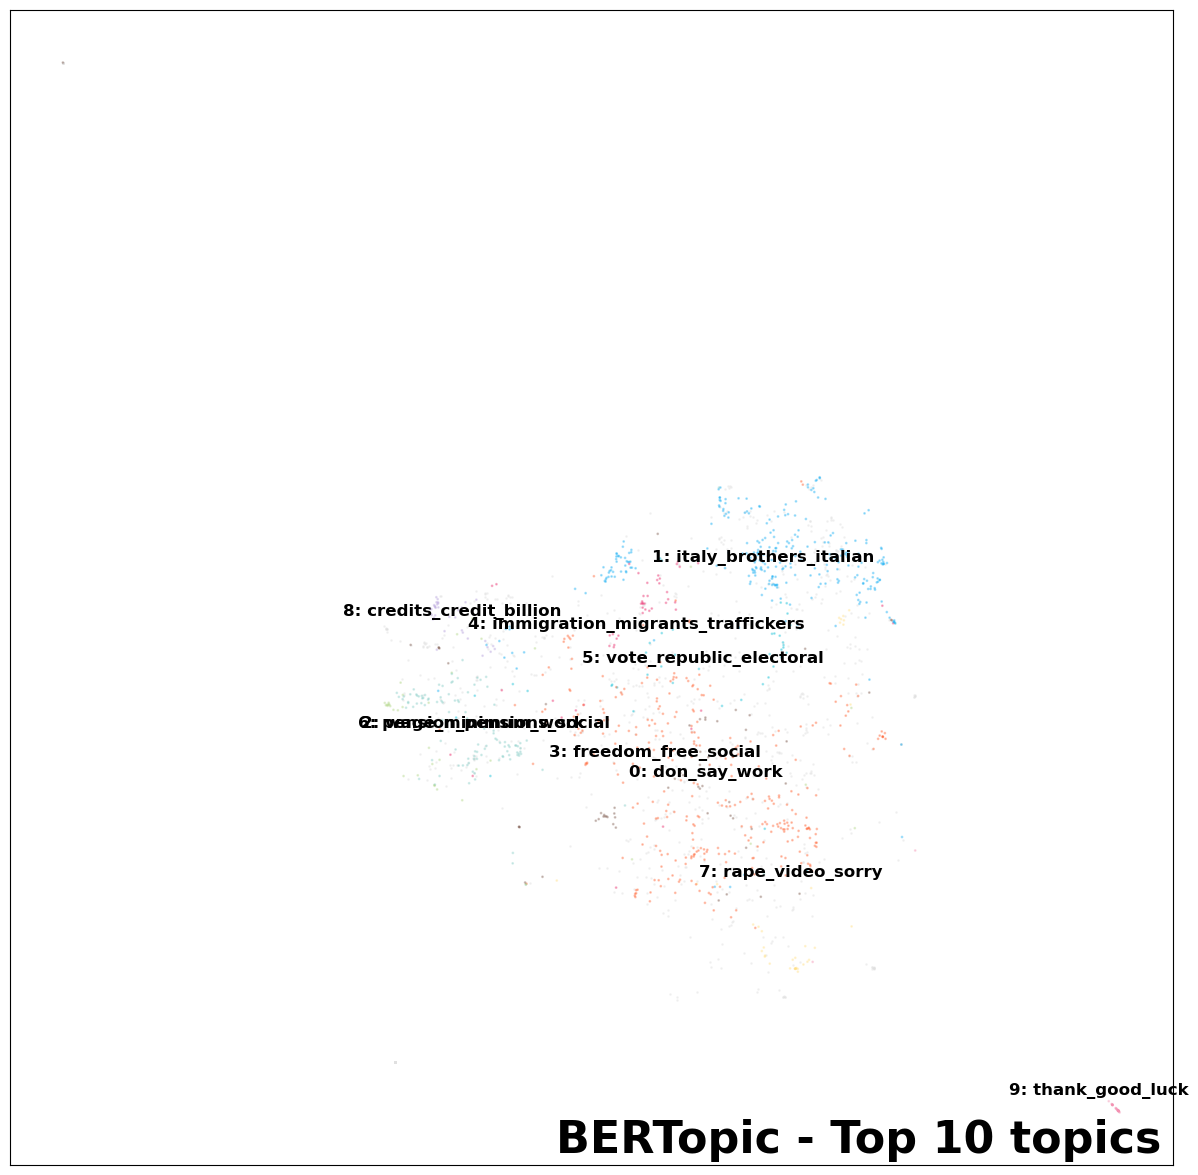

In [284]:
import matplotlib
import matplotlib.pyplot as plt

# Prepare data for plotting
embeddings = topic_model._extract_embeddings(docs, method="document")
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics

# Plot parameters
top_n = 10
fontsize = 12

# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]

# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                         '#03A9F4', # Blue
                                         '#4CAF50', # Green
                                         '#80CBC4', # FFEB3B
                                         '#673AB7', # Purple
                                         '#795548', # Brown
                                         '#E91E63', # Pink
                                         '#212121', # Black
                                         '#00BCD4', # Light Blue
                                         '#CDDC39', # Yellow/Red
                                         '#AED581', # Light Green
                                         '#FFE082', # Light Orange
                                         '#BCAAA4', # Light Brown
                                         '#B39DDB', # Light Purple
                                         '#F48FB1', # Light Pink
                                         ])

# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
    topic = int(row[1].topic)
    text = f"{topic}: " + "_".join([x[0] for x in topic_model.get_topic(topic)[:3]])
    ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')

ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [ ]:
topic_model.hierarchical_topics(docs)

# semi supervised topics model
# topic_model.fit(docs, y = y)

# incremental topic modelling
# topic_model.partial_fit(docs)

# Dynamci topics topics over time
# topic_model.topics_over_time(docs, timestamps=)

# class based topic modelling
# topic_model.topics_per_class(docs, classes)
The stop word vec taht does nto work.
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
topic_model.get_topic_info().head(50)